Custom implementation of the Inductive Item Tree Analysis <br>
The original, corrected and minimized corrected versions according to Sargin & Uenlue 2009

# IITA

In [1]:
# HYPERPARAMETERS
N_ITEMS = 9         #10
TAU = 0.09           #.19
N_PATTERNS = 2700  #1900
SEED = 7790            #19

## Vocabulary to associate B and items
ids = range(N_ITEMS)
nodes = [chr(i+97) for i in range(N_ITEMS)]
vocab = {ids[i]: nodes[i] for i in range(len(ids))}

## Implementation

### PREPARATION

In [5]:
%cd /content/drive/MyDrive/Github/BA/IITA
%ls

/content/drive/MyDrive/Github/BA/IITA
IITA_comparison.ipynb  IITA.ipynb  simulated_data.csv


In [6]:
# !pip install networkx
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import copy
import pylab as pl
from IPython import display
import time
import re

In [7]:
def generate_relation(n_items = N_ITEMS, m_samples = N_PATTERNS, seed = None):
  if seed: random.seed(seed)
  items = [chr(i+97) for i in range(n_items)]
  pairs = []
  for i in range(n_items):
    for j in range(i + 1, n_items):
        pairs.append((items[i], items[j]))
  delta = random.normalvariate(0.16, 0.06)
  delta = max(0, min(delta, 0.3))

  # UNDERLYING QUASI-ORDER
  relation = []
  for pair in pairs:
    if random.random() < delta:
      relation.append(pair)
  elements = sorted(set(e for pair in relation for e in pair))


  transitive_closure = {}
  for item in items:
      transitive_closure[item] = set()
      transitive_closure[item].add(item)
  for pair in relation:
      item1, item2 = pair
      transitive_closure[item1].add(item2)

  for k in elements:
    for i in elements:                                                          # logical consequence (since pair(i,j) <=> iRj <=> j->i)
      for j in elements:                                                        # logical antecedent
        if i != j and k in transitive_closure[i] and j in transitive_closure[k]:
          transitive_closure[i].add(j)                                          # Adds indirect relations iteratively

  quasi_order = [(i, j) for i, values in transitive_closure.items() for j in values]
  return items, quasi_order

In [8]:
def sample_knowledge_states(items, quasi_order, num_patterns = N_PATTERNS, seed = None):
    if seed: random.seed(seed)
    knowledge_states = []

    index = 0
    while index < num_patterns:
        state = []
        for item in items:
            response = random.randint(0, 1)
            state.append(response)
        is_consistent = all((state[items.index(j)] <= state[items.index(i)]) for i, j in quasi_order)
        if is_consistent:
            knowledge_states.append(state)
            index += 1

    return knowledge_states

In [9]:
def apply_error(states, tau = TAU, seed = None):
    if seed: random.seed(seed)
    patterns = copy.deepcopy(states)
    for state_index, state in enumerate(states):
        for i in range(len(state)):
            if random.random() < tau:
                if state[i]==1: patterns[state_index][i] = 0
                else: patterns[state_index][i] = 1

    data_matrix = np.array(patterns)
    return data_matrix

In [10]:
def counter_examples(D) :
  n = D.shape[1]
  B = np.zeros(shape=(n,n), dtype=int)
  for (i,j), e in np.ndenumerate(B) :
    for d in D :
      if (d[j] == 1) and (d[i] == 0):
        B[i,j] += 1
  return B

In [11]:
def transitive(t, R) :
    R_reduced = [ (i,j) for (i,j) in R if i!=j]
    if R :
      for e in R_reduced :
        if t[0] == e[1] and (e[0], t[1]) not in R :
          return False
        elif e[0] == t[1] and (t[0], e[1]) not in R :
          return False
    return True

In [12]:
def construct_relations(B, m = N_PATTERNS):
  relations = []
  current = []

  ## Constructs one model (quasi-order) for each tolerance level L
  for L in range(m):
    if relations:
      current = relations[-1]

    ## Potential implications (i,j) in A
    ##   for the current relation (quasiorder)
    ##   with associated tolerance level l <= L
    A1 = []                                                                     ### TODO...
    for (i,j),_ in np.ndenumerate(B):
      if (B[i,j] < L+1) and ((vocab[i],vocab[j]) not in current):
        A1 += [(vocab[i],vocab[j])]
    ## excludes implications that cause intransitivity to potential new relation (quasi-order)
    A2 = []
    for (i,j) in A1:
      if transitive((i,j), current + A1):  ###### ...  all((state[items.index(j)] <= state[items.index(i)]) for i, j in quasi_order)  ...
        A2 += [(i,j)]

    next_r = current + A2
    ## store new models (quasi-orders)
    # if A2:
      # if next_r not in relations:
    relations += [next_r]

  return relations

### Variants

In [13]:
def original_errors(D, B, selection_set) :
  n = D.shape[1]
  m = D.shape[0]
  P = D.sum(axis = -2) / m
  errors = []
  for R in selection_set :
    gamma = 0
    for (i,j), _ in np.ndenumerate(B) :
      if (vocab[i],vocab[j]) in R and i!=j :
        gamma += (B[i,j] / (P[j] * m))
    if len(R) - n > 0:
      errors += [gamma / (len(R) - n)]
    else :
      errors += [1]
  return errors

In [14]:
def minimized_errors(D, B, selection_set) :
  n = D.shape[1]
  m = D.shape[0]
  P = D.sum(axis = -2) / m
  errors = []

  for R in selection_set :
    x1, x2, x3, x4 = [0,0,0,0]
    for (i,j), _ in np.ndenumerate(B) :
      if i!=j:
        if (vocab[i],vocab[j]) not in R and (vocab[j],vocab[i]) in R :
          x1 += (-2 * B[i,j] * P[i] * m +
                  2 * P[i] * P[j] * (m**2) -
                  2 * (P[i]**2) * m**2 )
          x3 += 2 * P[i]**2 * m**2
        if (vocab[i],vocab[j]) in R :
          x2 += -2 * B[i,j] * P[j] * m
          x4 += 2 * P[j]**2 * m**2
    if x3 == 0 or x4 == 0:
      gamma = 1
    else:
      gamma = -1 * ((x1+x2) / (x3+x4))
    if len(R) - n > 0:
      errors += [gamma]
    else :
      errors += [1]                                                             # Default error value when there are no implications

  return errors

In [15]:
def original_expectation(D, B, quasi_orders, errors) :
  if np.any(np.apply_along_axis(np.sum, axis=0, arr=D) == 0):                   # Each item solved?
    raise ValueError("each item must be solved at least once")
  n = D.shape[1]
  m = D.shape[0]
  P = D.sum(axis = -2) / m
  Targets = np.zeros(shape=(1, n, n))

  for R_index, R in enumerate(quasi_orders) :
    if R_index > 0:
      t = np.zeros(shape=(1, n, n))
    ####################################
      for (i,j), _ in np.ndenumerate(B) :
        if (vocab[i],vocab[j]) not in R and i!=j:
          ## ...
          t[:,i,j] = (1 - P[i]) * P[j] * m * (1 - errors[R_index])
        if (vocab[i],vocab[j]) in R and i!=j :
          ## ...
          t[:,i,j] = errors[R_index] * P[j] * m
    ####################################
      Targets = np.concatenate( (Targets, t), axis=0)

  return copy.deepcopy(Targets)

In [16]:
def corrected_expectation(D, B, quasi_orders, errors) :
  if np.any(np.apply_along_axis(np.sum, axis=0, arr=D) == 0):
    raise ValueError("each item must be solved at least once")

  n = D.shape[1]
  m = D.shape[0]
  P = D.sum(axis = -2) / m
  Targets = np.zeros(shape=(1, n, n))

  for R_index, R in enumerate(quasi_orders) :
    if R_index > 0:
      t = np.zeros(shape=(1, n, n))
    ####################################
      for (i,j), _ in np.ndenumerate(B) :
        if (vocab[i],vocab[j]) not in R and (vocab[j],vocab[i]) not in R:
          t[:,i,j] = (1 - P[i]) * P[j] * m
        elif (vocab[i],vocab[j]) not in R and (vocab[j],vocab[i]) in R:
          t[:,i,j] = (P[j] - (P[i] - (P[i] * errors[R_index]) )) * m
        elif (vocab[i],vocab[j]) in R and i!=j :
          t[:,i,j] = errors[R_index] * P[j] * m

          if (P[j] - (P[i] - (P[i] * errors[R_index])) < 0):
            t[:,i,j] = 0
    ####################################
      Targets = np.concatenate( (Targets, t), axis=0)
  return Targets

In [17]:
def difference(B, Targets) :
  n = B.shape[0]
  difference_values = []
  diff = 0

  for index, _ in enumerate(Targets) :
    sum = 0
    for (i,j), b in np.ndenumerate(B) :
      if i!=j :
        sum += (b - Targets[index,i,j]) ** 2
    # diff = sum / (n**2 - n)
    diff = sum / (2*n * (2 * (n-1)))
    difference_values += [diff]

  return difference_values

In [18]:
def evaluate(quasi_orders, difference_values) :
  indices = [index for index, item in enumerate(difference_values) if item == min(difference_values)]
  return quasi_orders[indices[0]]

### main

In [19]:
items, true_quasi_order = generate_relation(n_items = N_ITEMS, seed = SEED)
states = sorted(sample_knowledge_states(items, true_quasi_order, N_PATTERNS, SEED))
D = apply_error(states, TAU, SEED)
# Matrix to examine errors  of the true underlying
#diff = np.where(D < np.array(states), 1, np.where(D > np.array(states), 2, 0))

b_ij = counter_examples(D)
selection_set = construct_relations(b_ij, N_PATTERNS)

In [ ]:
### Use this cell to run iita on given csv dataset:
# Control_data = np.genfromtxt('simulated_data.csv', delimiter=',', skip_header=1)
# D = Control_data

# b_ij = counter_examples(D)
# selection_set = construct_relations(b_ij, D.shape[0])

In [20]:
# errors = original_errors(D, b_ij, selection_set)
errors = minimized_errors(D, b_ij, selection_set)
# estimates = original_expectation(D, b_ij, selection_set, errors)
estimates = corrected_expectation(D, b_ij, selection_set, errors)

fit = difference(b_ij, estimates[1:,:,:])
solution = evaluate(selection_set, fit)
non_reflexive_solution = [b for b in solution if b[0]!=b[1]]

## Comparison
with the authors original implementation ("DAKS" R-package)

In [21]:
re_dict = {value: key for key, value in vocab.items()}
non_ref_true_quasi_order = [b for b in true_quasi_order if b[0]!=b[1]]
print("Input (DAKS): <", ', '.join(sorted([f"tuple({re_dict[i]+1},{re_dict[j]+1})" for (i,j) in non_ref_true_quasi_order])), ">")

Input (DAKS): < tuple(1,7), tuple(1,8), tuple(1,9), tuple(4,8), tuple(4,9), tuple(6,8), tuple(7,8) >


In [22]:
# Copy DAKS results into "R_solution" and run for comparison:
R_solution = "{(1L, 7L), (1L, 8L), (1L, 9L), (4L, 8L), (4L, 9L), (6L, 8L), (7L, 8L)}"

In [23]:
R_solution = re.findall(r'\d+', R_solution) #[(i,j) for re.findall(r'\d+', R_output)]   ### [(numbers[i], numbers[i + 1]) for i in range(0, len(numbers), 2)]
R_solution = [(int(R_solution[i])-1,int(R_solution[i+1])-1) for i in range(0, len(R_solution), 2)]
R_solution = [(vocab[i],vocab[j]) for (i,j) in R_solution];

In [24]:
print("Underlying:       ", non_ref_true_quasi_order )
print("Solution:         ", non_reflexive_solution)
print("Control solution: ", R_solution)

Underlying:        [('a', 'g'), ('a', 'h'), ('a', 'i'), ('d', 'h'), ('d', 'i'), ('f', 'h'), ('g', 'h')]
Solution:          [('a', 'h'), ('a', 'i'), ('d', 'h'), ('f', 'h'), ('a', 'g')]
Control solution:  [('a', 'g'), ('a', 'h'), ('a', 'i'), ('d', 'h'), ('d', 'i'), ('f', 'h'), ('g', 'h')]


## Validation

### VIZ

In [25]:
def viz_relation(items, relation, mode="Binary relations", seed=None, title="Directed Graph of Relation"):
  if mode == "Implications":
    relation = [(j, i) for i, j in relation] # Depict implications (instead of relation)
  G = nx.DiGraph()
  G.add_nodes_from(items)
  G.add_edges_from(relation)

  plt.figure(figsize=(8, 6))  # Set the figure size
  plt.title(title)
  plt.suptitle(f"Edges representation mode: {mode}", fontsize=9)

  if seed!=None:
    pos = nx.spring_layout(G, seed=seed)
  else:
    pos = nx.spring_layout(G)
  nx.draw(G, pos=pos, with_labels=True, font_weight='bold')

  # time.sleep(2)
  display.clear_output(wait=True)
  display.display(pl.gcf())
  pl.close()

### Plot

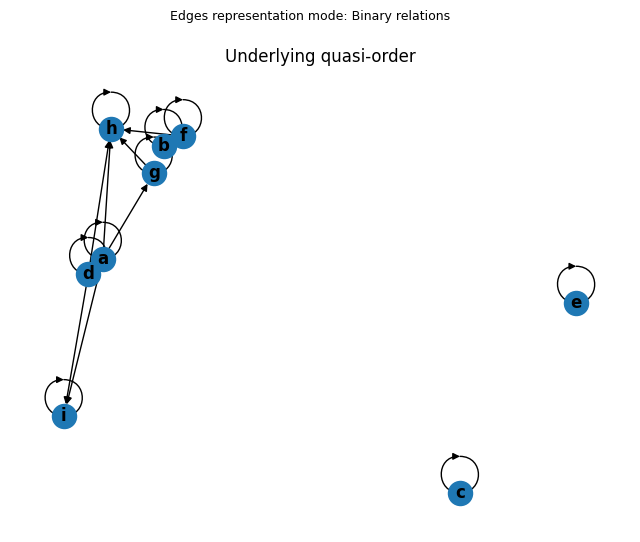

In [26]:
viz_relation(items, true_quasi_order, seed=SEED, title="Underlying quasi-order")

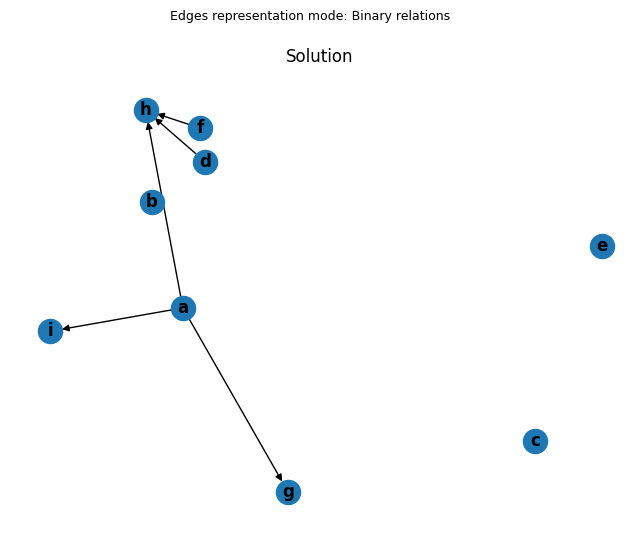

Missing/False implications: {('d', 'i'), ('g', 'h')}


In [27]:
viz_relation(items, non_reflexive_solution, mode="Binary relations", seed=SEED, title="Solution")
errors = set(true_quasi_order).difference(solution) | set(solution).difference(true_quasi_order)
print(f"Missing/False implications: {errors}")

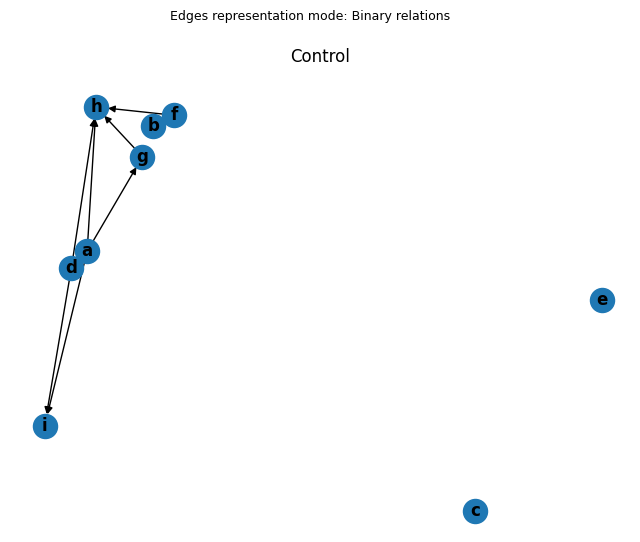

Missing/False implications: set()


In [28]:
viz_relation(items, R_solution, seed=SEED, title="Control")
errors = set(non_ref_true_quasi_order).difference(R_solution) | set(R_solution).difference(non_ref_true_quasi_order)
print(f"Missing/False implications: {errors}")